In [1]:
# import library untuk dataframe dan visualisasi

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
# import library untukk clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [3]:
import os
os.getcwd()

'C:\\Users\\angelina\\Pictures\\DATMIN\\CLUSTERING'

In [4]:
# load data

retail = pd.read_csv('OnlineRetail.csv', sep=",", encoding="ISO-8859-1", header=0)
retail.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,01-12-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,01-12-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,01-12-2010 08:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,01-12-2010 08:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,01-12-2010 08:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,01-12-2010 08:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,01-12-2010 08:34,1.69,13047.0,United Kingdom


In [5]:
# shape of df

retail.shape

(541909, 8)

In [6]:
# df info

retail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null object
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
# df deskripsi

retail.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [8]:
# DATA PREPROCESSING
# menghitung data yang hilang % contribution di DF
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo       0.00
StockCode       0.00
Description     0.27
Quantity        0.00
InvoiceDate     0.00
UnitPrice       0.00
CustomerID     24.93
Country         0.00
dtype: float64

In [9]:
# menghapus data yang tidak mempunyai nilai

retail = retail.dropna()
retail.shape

(406829, 8)

In [10]:
# mengubah tipe data Customer Id 
retail['CustomerID'] = retail['CustomerID'].astype(str)

In [11]:
#DATA PREPARATION

# membuat atribut baru : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [12]:
# membuat atribut baru : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [13]:
# menyatukan kedua  dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [14]:
# membuat atribut baru : Recency

# mengconvert datatime ke propoer

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [15]:
# menghitung tanggal maksimum untuk mengetahui tanggal trakhir transaksi

max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [16]:
# menghitung perbedaan kedua tanggal (maksimal dan tgl transaksi)

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


In [17]:
# menghitung tanggal transaksi terakhir untuk mendapatkan kebaruan pelanggan 

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [18]:
# mengekstract number hanya harinya  saja 

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [19]:
# menyuatuja dataframe untuk mendapatkan akhir RFM dataframe 

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

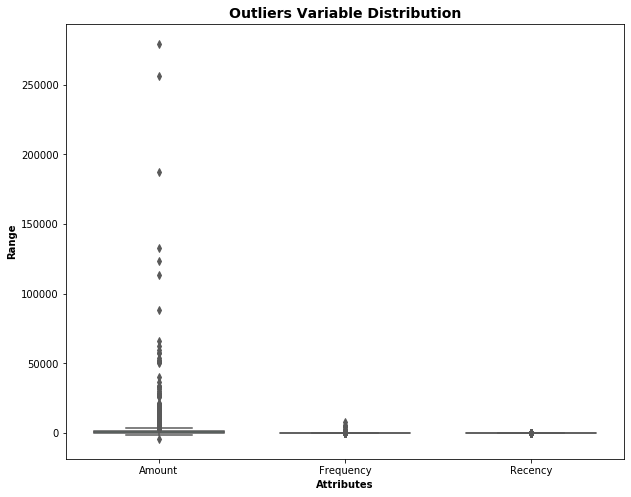

In [20]:
# Analisis outlier Jumlah Frekuensi dan Keterkinian 

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [21]:
# menghapus (statistical) outliers dari  Amount
Q1 = rfm.Amount.quantile(0.05)
Q3 = rfm.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# menghapus (statistical) outliers dari Recency
Q1 = rfm.Recency.quantile(0.05)
Q3 = rfm.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# menghapus (statistical) outliers dari Frequency
Q1 = rfm.Frequency.quantile(0.05)
Q3 = rfm.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [22]:
# Rescaling  attribu

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = StandardScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(4293, 3)

In [23]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,-0.723738,-0.752888,2.301611
1,1.731617,1.042467,-0.906466
2,0.300128,-0.463636,-0.183658
3,0.277517,-0.044720,-0.738141
4,-0.533235,-0.603275,2.143188


In [24]:
from sklearn.preprocessing import MinMaxScaler

In [25]:
x_array =  np.array(rfm)
print(x_array)

[['12346.0' 0.0 2 325]
 ['12347.0' 4309.999999999997 182 1]
 ['12348.0' 1797.24 31 74]
 ...
 ['18281.0' 80.82 7 180]
 ['18282.0' 176.59999999999997 13 7]
 ['18287.0' 1837.2799999999997 70 42]]


In [26]:
scaler = MinMaxScaler()
rfm_df_scaled = scaler.fit_transform(x_array)
rfm_df_scaled

array([[0.00000000e+00, 2.38662816e-01, 1.39470014e-03, 8.71313673e-01],
       [1.68321831e-04, 4.78570816e-01, 2.52440725e-01, 2.68096515e-03],
       [3.36643663e-04, 3.38702782e-01, 4.18410042e-02, 1.98391421e-01],
       ...,
       [9.98990069e-01, 2.43161509e-01, 8.36820084e-03, 4.82573727e-01],
       [9.99158391e-01, 2.48492921e-01, 1.67364017e-02, 1.87667560e-02],
       [1.00000000e+00, 3.40931533e-01, 9.62343096e-02, 1.12600536e-01]])

In [28]:
#MENEMUKAN JUMLAH OPTIMAL CLUSTER
# Elbow-curve/SSD

# ssd = []
# range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
# for num_clusters in range_n_clusters:
#     kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
#     kmeans.fit(rfm_df_scaled)
    
#     ssd.append(kmeans.inertia_)
    
# # plot  SSDs untuk  n_clusters lain
# plt.plot(ssd)

In [29]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    
    # inisialisasi kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    

For n_clusters=2, the silhouette score is 0.3351453484015061
For n_clusters=3, the silhouette score is 0.3970559894355392
For n_clusters=4, the silhouette score is 0.3872403793210062
For n_clusters=5, the silhouette score is 0.39714403579043633
For n_clusters=6, the silhouette score is 0.3411167760375684
For n_clusters=7, the silhouette score is 0.3454504247102741
For n_clusters=8, the silhouette score is 0.33951842364705104


In [30]:
# Final model dengan k=3
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
 kmeans.labels_

array([1, 0, 0, ..., 2, 2, 2])

In [32]:
print(kmeans.cluster_centers_)

[[0.2394001  0.33112912 0.12507228 0.11949033]
 [0.50090586 0.26157305 0.03547575 0.69476631]
 [0.75322469 0.31467665 0.1285735  0.12392729]]


In [33]:
# assign the label
rfm['Cluster_Id'] = kmeans.labels_
rfm.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


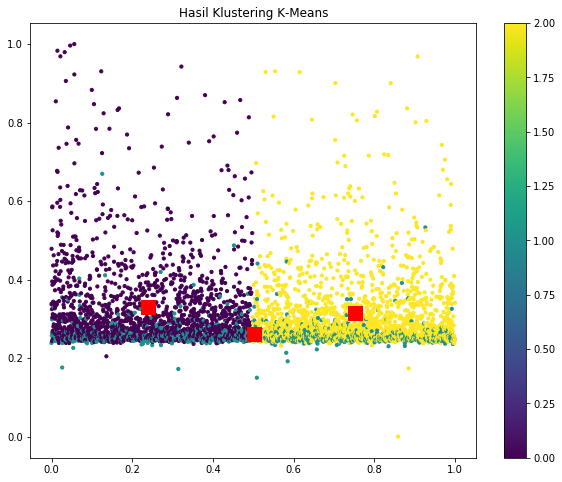

In [34]:
output = plt.scatter(rfm_df_scaled[:,0], rfm_df_scaled[:,1], s = 10, c = rfm.Cluster_Id, marker = "o", alpha = 1, )
centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='red', s=200, alpha=1 , marker="s" );
plt.title("Hasil Klustering K-Means")
plt.colorbar (output)
plt.show()

In [35]:
hasil = rfm[rfm["Cluster_Id"]==0]
hasil.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
1,12347.0,4310.00,182,1,0
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
5,12352.0,1545.41,95,35,0
6,12353.0,89.00,4,203,0


In [36]:
hasil = rfm[rfm["Cluster_Id"]==1]
hasil.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.0,2,325,1
4,12350.0,334.4,17,309,1
7,12354.0,1079.4,58,231,1
8,12355.0,459.4,13,213,1
14,12361.0,189.9,10,286,1


In [37]:
hasil = rfm[rfm["Cluster_Id"]==2]
hasil.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
2174,15286.0,240.55,3,49,2
2182,15297.0,635.04,41,9,2
2185,15300.0,496.44,28,63,2
2188,15304.0,680.30,26,60,2
2189,15306.0,1174.35,58,63,2
